In [1]:
import warnings
import json
warnings.filterwarnings("ignore")

In [ ]:
!pip install fastai

In [2]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
# Replace with correct kaggle credentials
kaggle_credentials = {
    "username": "tarekziad",
    "key": "40b30aa49d333ec3eeafe32b7584f421"
}

# Write the new kaggle.json file
with open('kaggle.json', 'w') as file:
    json.dump(kaggle_credentials, file)

print("kaggle.json created successfully.")

kaggle.json created successfully.


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
!unzip semantic-segmentation-of-aerial-imagery.zip > /dev/null

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
 95% 28.0M/29.6M [00:00<00:00, 150MB/s] 
100% 29.6M/29.6M [00:00<00:00, 144MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('/content/semantic-segmentation-of-aerial-imagery.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [7]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List TPUs available
tpus = tf.config.list_physical_devices('TPU')
print("TPUs:", tpus)

# Check if TPUs are available
if tpus:
    print("TPU is available.")
else:
    print("TPU is not available.")

# Set up TPU strategy
if tpus:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Automatically detect TPU in Colab
    tf.config.experimental_connect_to_cluster(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("Using TPU Strategy:", strategy)
else:
    print("No TPU detected. Ensure TPU runtime is enabled.")


TensorFlow version: 2.15.0
TPUs: [PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]
TPU is available.
Using TPU Strategy: <tensorflow.python.distribute.tpu_strategy.TPUStrategyV2 object at 0x7af5b036a890>


In [ ]:


import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# List GPUs available
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

# Check if GPUs are available
if gpus:
    print("GPU is available.")
else:
    print("GPU is not available.")

# Set memory growth for each GPU
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)



In [8]:
!pip install matplotlib > /dev/null
!pip install scikit-learn > /dev/null
!pip install -U segmentation-models > /dev/null
!pip install patchify > /dev/null
!pip install Pillow > /dev/null


**Patchify images and masks**

In [9]:
import os
import cv2
import numpy as np

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Segmentation Models: using `tf.keras` framework.


In [10]:
root_directory = "/content/data/Semantic segmentation dataset"

scaler = MinMaxScaler()
patch_size = 256

In [11]:
image_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images

                image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        image_dataset.append(single_patch_img)

Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_001.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_002.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_003.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_004.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_005.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_006.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_007.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_008.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 2/images/image_part_009.jpg
Now patchifying image: /content/data/Semantic segmentation dataset/Tile 7/images/image_part_001.jpg


In [12]:
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images

                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = np.array(mask)

                #Extract patches from each image
                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_001.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_002.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_003.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_004.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_005.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_006.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_007.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_008.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 2/masks/image_part_009.png
Now patchifying mask: /content/data/Semantic segmentation dataset/Tile 7/masks/image_part_001.png
Now patchifying mask

In [13]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [14]:
print("Number of images in dataset:", len(image_dataset))
print("Number of masks in dataset:", len(mask_dataset))

Number of images in dataset: 1305
Number of masks in dataset: 1305


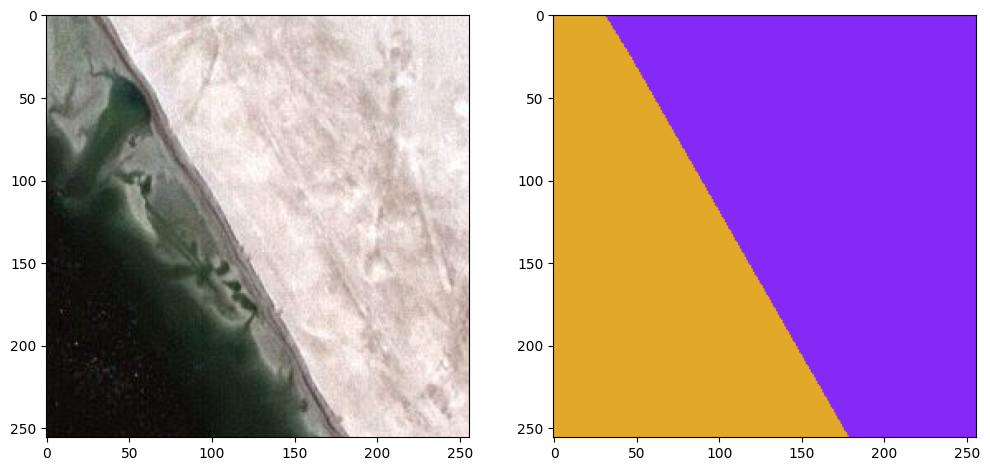

In [15]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [16]:
#Convert HEX to RGB array

a=int('3C', 16)  #3C with base 16. Should return 60.
print(a)
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

label = single_patch_mask

60


In [17]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]

    return label_seg

In [18]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


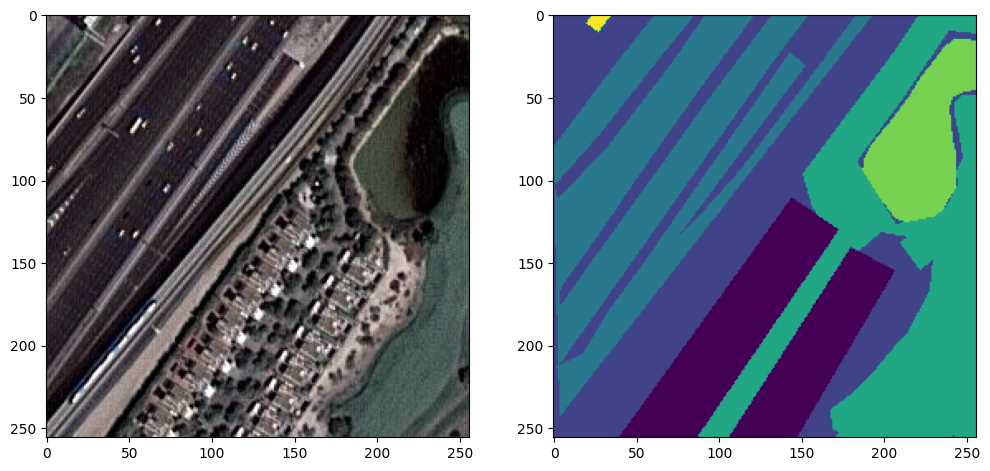

In [19]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [20]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K



In [21]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

## **Bayesian Change Detection/ PSPNet**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_80 (Conv2D)          (None, 256, 256, 64)         1792      ['input_10[0][0]']            
                                                                                                  
 max_pooling2d_27 (MaxPooli  (None, 128, 128, 64)         0         ['conv2d_80[0][0]']           
 ng2D)                                                                                            
                                                                                                  
 conv2d_81 (Conv2D)          (None, 128, 128, 128)        73856     ['max_pooling2d_27[0][0]']

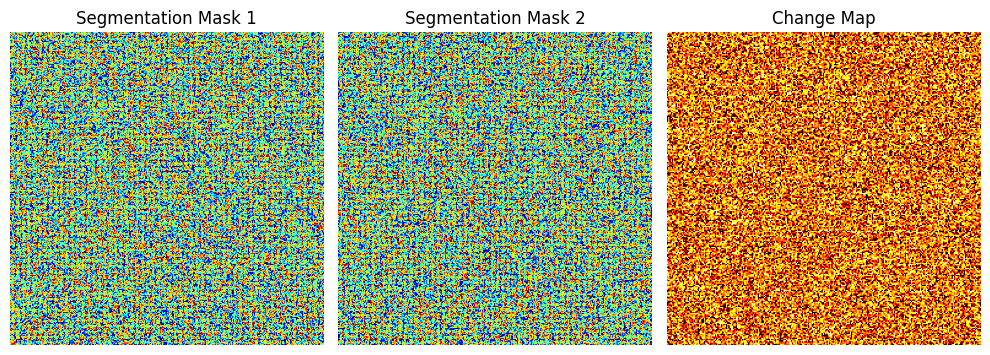

In [31]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     Dropout, concatenate, AveragePooling2D, Lambda)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import Metric
from scipy.stats import beta
import matplotlib.pyplot as plt

# Custom Jaccard Coefficient (Intersection over Union) as Keras Metric
class JaccardCoefficient(Metric):
    def __init__(self, name='jaccard_coef', **kwargs):
        super(JaccardCoefficient, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name='intersection', initializer='zeros', dtype=tf.float32)
        self.union = self.add_weight(name='union', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Binarize predictions

        intersect = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
        union = tf.reduce_sum(y_true + y_pred, axis=[1,2,3]) - intersect

        self.intersection.assign_add(tf.reduce_sum(intersect))
        self.union.assign_add(tf.reduce_sum(union))

    def result(self):
        return tf.math.divide_no_nan(self.intersection, self.union)

    def reset_states(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

# Calculate class distribution for segmentation masks
def calculate_class_distribution(mask):
    unique, counts = np.unique(mask, return_counts=True)
    class_distribution = dict(zip(unique, counts / counts.sum()))
    return class_distribution

# Bayesian change detection function with Beta distribution
def bayesian_change_detection(mask1, mask2, alpha_prior=1.0, beta_prior=1.0):
    unique_labels = np.unique(np.concatenate([mask1, mask2]))  # All possible class labels
    change_map = np.zeros_like(mask1, dtype=float)

    for class_label in unique_labels:
        class_mask1 = (mask1 == class_label).astype(int)
        class_mask2 = (mask2 == class_label).astype(int)

        n1 = np.sum(class_mask1)
        n2 = np.sum(class_mask2)

        posterior1 = beta(alpha_prior + n1, beta_prior + (class_mask1.size - n1))
        posterior2 = beta(alpha_prior + n2, beta_prior + (class_mask2.size - n2))

        change_prob = np.abs(posterior1.mean() - posterior2.mean())
        change_map[np.logical_or(class_mask1, class_mask2)] = change_prob

    return change_map

# PSPNet model architecture with refinements
def pspnet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    # Feature Extraction
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)  # 128x128
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)  # 64x64
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)  # 32x32
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)  # 32x32

    # Pyramid Pooling Module
    def pyramid_pooling_module(x, pool_size):
        pooled = AveragePooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
        pooled = Conv2D(128, (1, 1), activation='relu', padding='same')(pooled)
        pooled = Lambda(lambda y: tf.image.resize(y, size=(32, 32), method='bilinear'))(pooled)
        return pooled

    pool_sizes = [1, 2, 3, 6]
    pool_layers = [pyramid_pooling_module(x, size) for size in pool_sizes]

    # Concatenate Pyramid Pooling Layers with Main Feature Map
    x = concatenate([x] + pool_layers, axis=-1)  # Shape: (32, 32, 512 + 4*128) = (32,32,1024)

    # Further Refinement
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # 64x64

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # 128x128

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # 256x256

    # Final Convolution with Softmax Activation
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(x)  # 256x256xN

    model = Model(inputs, outputs)
    return model

# Compile and return PSPNet model
def get_model():
    return pspnet_model(n_classes=6, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

# Instantiate and compile the model
model = get_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=categorical_crossentropy,
              metrics=['accuracy', JaccardCoefficient()])

model.summary()

# Example usage for Bayesian change detection
if __name__ == "__main__":
    # Generate example segmentation masks
    segmentation_mask_1 = np.random.randint(0, 6, (256, 256))  # Example mask 1
    segmentation_mask_2 = np.random.randint(0, 6, (256, 256))  # Example mask 2

    # Perform Bayesian Change Detection
    change_map = bayesian_change_detection(segmentation_mask_1, segmentation_mask_2)

    # Print the class distribution for one mask
    print("Class distribution in mask 1:", calculate_class_distribution(segmentation_mask_1))

    # Visualize the change map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Segmentation Mask 1")
    plt.imshow(segmentation_mask_1, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Segmentation Mask 2")
    plt.imshow(segmentation_mask_2, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Change Map")
    plt.imshow(change_map, cmap='hot')
    plt.axis('off')

    plt.tight_layout()
    plt.show()


**Train PSPNet - Bayesian Change Detection  model with the preprocessed dataset**

In [32]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/30
66/66 [==============================] - 155s 2s/step - loss: 1.2313 - accuracy: 0.5430 - jaccard_coef: 0.3501 - val_loss: 1.0333 - val_accuracy: 0.6031 - val_jaccard_coef: 0.4209
Epoch 2/30
66/66 [==============================] - 151s 2s/step - loss: 0.8425 - accuracy: 0.6892 - jaccard_coef: 0.5253 - val_loss: 0.7647 - val_accuracy: 0.7255 - val_jaccard_coef: 0.5701
Epoch 3/30
66/66 [==============================] - 149s 2s/step - loss: 0.7466 - accuracy: 0.7354 - jaccard_coef: 0.5693 - val_loss: 0.7807 - val_accuracy: 0.7166 - val_jaccard_coef: 0.5674
Epoch 4/30
66/66 [==============================] - 149s 2s/step - loss: 0.6980 - accuracy: 0.7515 - jaccard_coef: 0.5900 - val_loss: 0.6889 - val_accuracy: 0.7565 - val_jaccard_coef: 0.6008
Epoch 5/30
66/66 [==============================] - 150s 2s/step - loss: 0.6614 - accuracy: 0.7659 - jaccard_coef: 0.6137 - val_loss: 0.6666 - val_accuracy: 0.7655 - val_jaccard_coef: 0.6085
Epoch 6/30
66/66 [===========================

**Save trained model to Kaggle Output**

In [33]:
path_model = '/content/data/working/satellites.hdf5'
model.save(path_model)

**Plot training and validation accuracy and loss at each epoch**

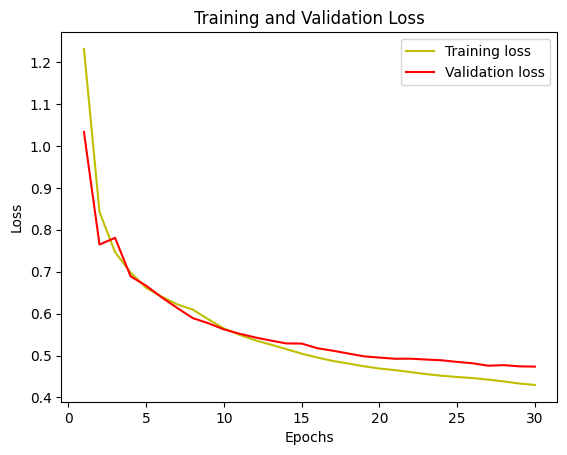

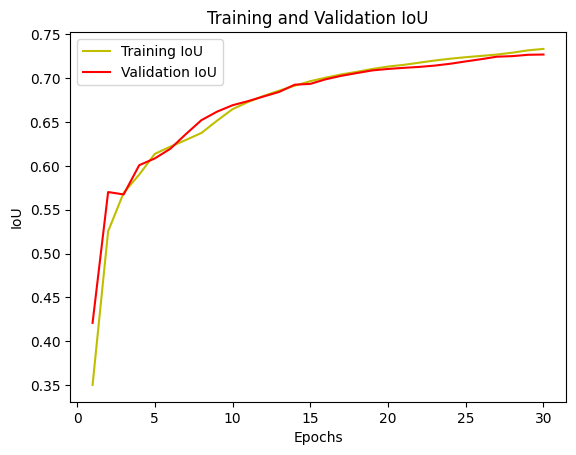

In [35]:
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the training and validation loss
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Correcting the key from 'jacard_coef' to 'jaccard_coef'
acc = history.history['jaccard_coef']
val_acc = history.history['val_jaccard_coef']

# Plotting the training and validation IoU
plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()


**Predict Using Saved Model**

In [36]:
import tensorflow as tf

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow.keras.models import load_model
import segmentation_models as sm
from tensorflow.keras import backend as K

# Define the custom loss functions
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  # Composite loss function

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)



In [37]:
# Path to your model
model_path = path_model

In [39]:
# Ensure you have TensorFlow environment variable set
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [42]:
import tensorflow as tf
import numpy as np
from keras.models import load_model

class JaccardCoefficient(tf.keras.metrics.Metric):
    def __init__(self, name='jaccard_coefficient', smooth=1e-6, **kwargs):
        super(JaccardCoefficient, self).__init__(name=name, **kwargs)
        self.smooth = smooth
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten the inputs
        y_true_f = tf.reshape(y_true, (-1,))
        y_pred_f = tf.reshape(y_pred, (-1,))

        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
        jac = (intersection + self.smooth) / (total - intersection + self.smooth)

        self.total.assign_add(jac)
        self.count.assign_add(1)

    def result(self):
        return self.total / self.count

    def reset_states(self):
        self.total.assign(0)
        self.count.assign(0)

# Ensure total_loss is defined in your context
# total_loss should be the loss function you are using

custom_objects = {
    "dice_loss_plus_1focal_loss": total_loss,
    "JaccardCoefficient": JaccardCoefficient
}

# Load the model with custom objects
model = load_model(model_path, custom_objects=custom_objects)

# IOU Calculation
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


9/9 [==============================] - 9s 990ms/step


In [43]:
#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.56368285


```
Benchmarking:

    Excellent: Mean IoU > 0.8
    Good: 0.6 < Mean IoU ≤ 0.8
    Moderate: 0.4 < Mean IoU ≤ 0.6
    Poor: Mean IoU ≤ 0.4

```

1/1 [==============================] - 0s 61ms/step


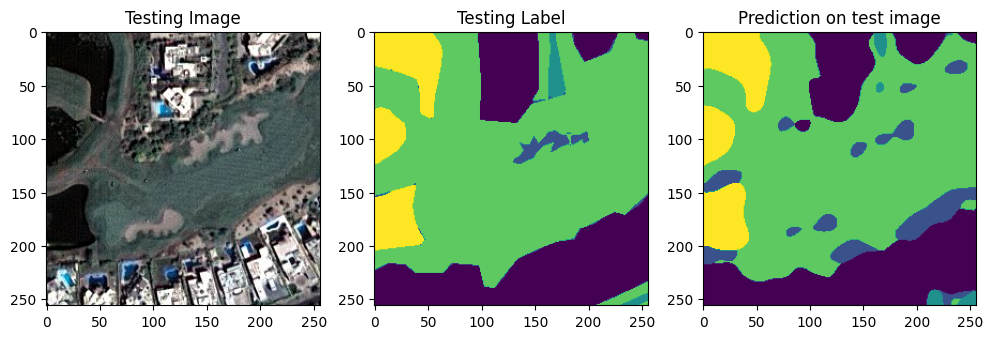

In [44]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

1/1 [==============================] - 0s 65ms/step


<Figure size 2000x2000 with 0 Axes>

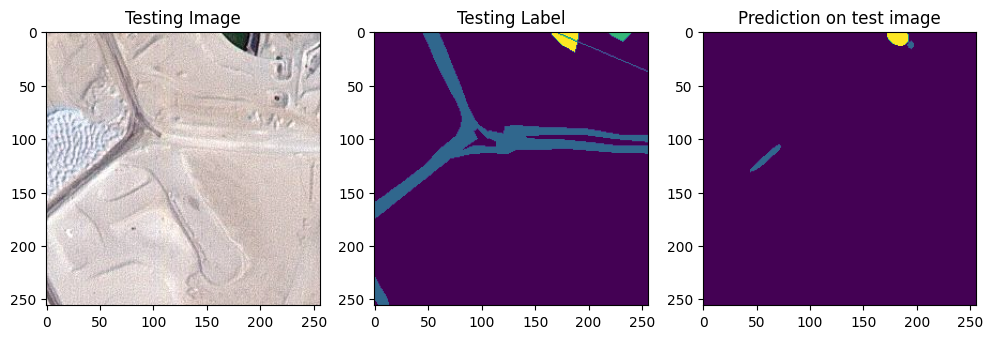

1/1 [==============================] - 0s 62ms/step


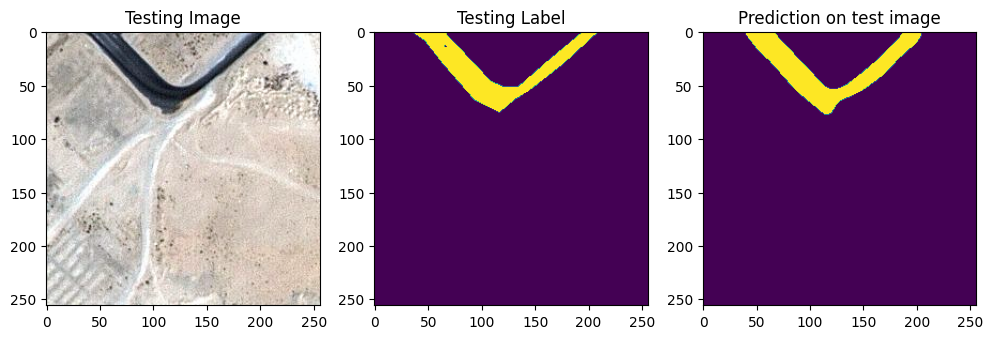

1/1 [==============================] - 0s 63ms/step


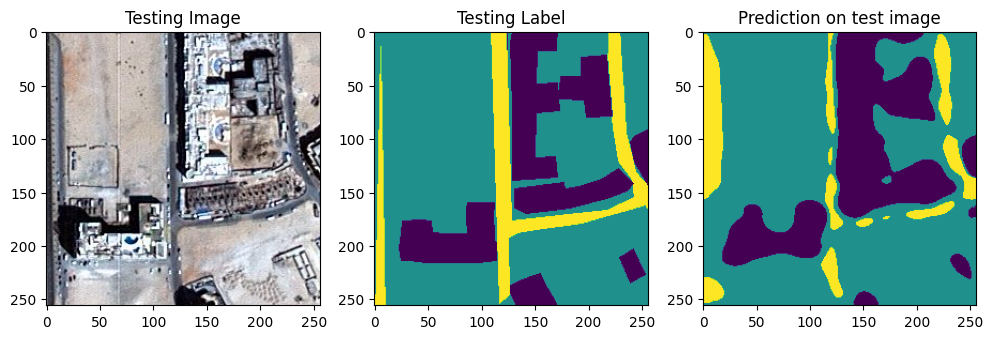

1/1 [==============================] - 0s 59ms/step


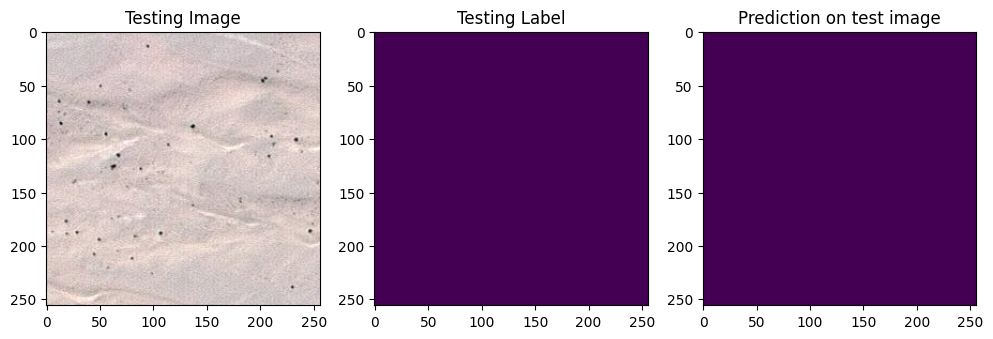

1/1 [==============================] - 0s 63ms/step


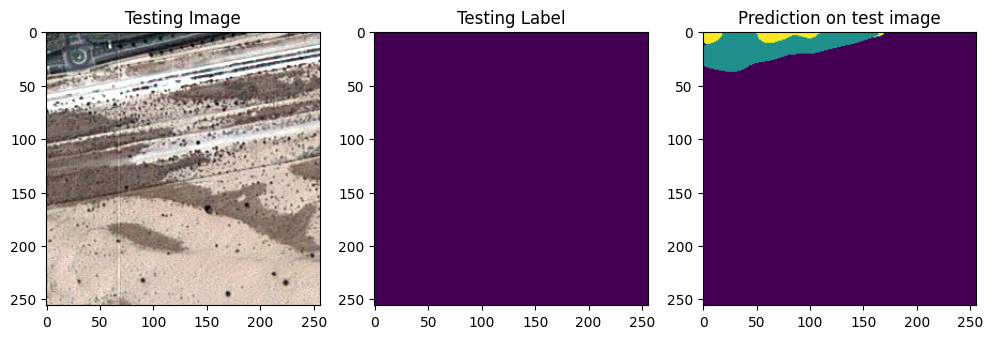

In [45]:
# Number of images to predict
num_images = 5

# Plot setup
plt.figure(figsize=(20, 20))

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth)
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img)
    plt.show()

In [46]:
import tensorflow as tf
from keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# Define number of classes
n_classes = 6

# IoU Metric
iou_keras = MeanIoU(num_classes=n_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())


import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Convert to one-hot encoding if not already (assuming y_true, y_pred are integer class labels)
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=n_classes)
    y_pred_one_hot = tf.one_hot(tf.cast(y_pred, tf.int32), depth=n_classes)

    # Flatten the one-hot encoded tensors for each class
    y_true_flat = tf.reshape(y_true_one_hot, [-1, n_classes])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, n_classes])

    # Compute Dice Coefficient per class and then average
    intersection = tf.reduce_sum(tf.cast(y_true_flat * y_pred_flat, tf.float32), axis=0)
    union = tf.reduce_sum(tf.cast(y_true_flat, tf.float32), axis=0) + tf.reduce_sum(tf.cast(y_pred_flat, tf.float32), axis=0)

    dice_per_class = (2. * intersection + smooth) / (union + smooth)
    dice_mean = tf.reduce_mean(dice_per_class)  # Average Dice coefficient across all classes

    return dice_mean

# Example usage
dice = dice_coefficient(y_test_argmax, y_pred_argmax)
print("Dice Coefficient =", dice.numpy())


# Precision and Recall
precision = precision_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
recall = recall_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted', zero_division=1)
print("Precision =", precision)
print("Recall =", recall)

# F1 Score
f1 = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average='weighted')
print("F1 Score =", f1)


import tensorflow as tf

def pixel_accuracy(y_true, y_pred):
    # Ensure both tensors are of the same type, here they're int64
    y_true = tf.cast(y_true, tf.int64)  # Make sure both are int64
    y_pred = tf.cast(y_pred, tf.int64)

    # Compute accuracy
    correct = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32))
    total = tf.size(y_true, out_type=tf.float32)  # Make sure the size is float for division
    return correct / total

# Example usage
accuracy = pixel_accuracy(y_test_argmax, y_pred_argmax)
print("Pixel Accuracy =", accuracy.numpy())




Mean IoU = 0.56368285
Dice Coefficient = 0.66536295
Precision = 0.8404441553177688
Recall = 0.842067616195971
F1 Score = 0.8372382363036225
Pixel Accuracy = 0.8420676


In [47]:
print("Data type of y_test_argmax:", y_test_argmax.dtype)
print("Data type of y_pred_argmax:", y_pred_argmax.dtype)


Data type of y_test_argmax: int64
Data type of y_pred_argmax: int64


In [48]:
path_model = '/content/data/working/satellite_standard_unetBayes1_100epochs.hdf5'
model.save(path_model)

9/9 [==============================] - 9s 987ms/step


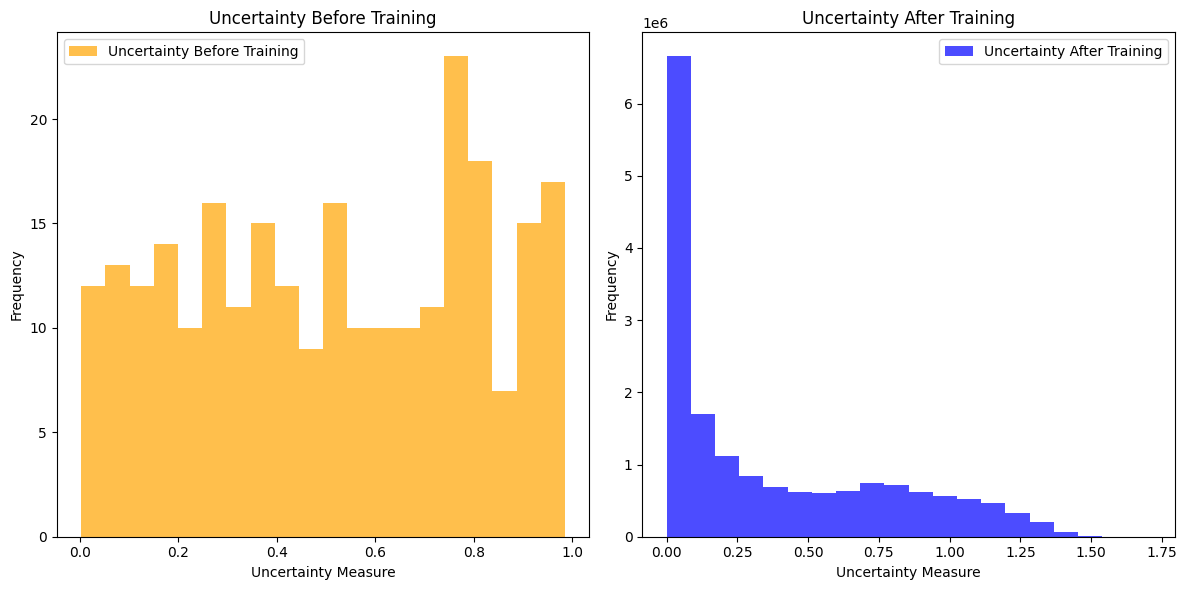

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import backend as K
from keras.metrics import Metric

# Define your custom metric class
class JaccardCoefficient(Metric):
    def __init__(self, name='jaccard_coef', **kwargs):
        super(JaccardCoefficient, self).__init__(name=name, **kwargs)
        self.ii = self.add_weight('intersection', shape=())
        self.uu = self.add_weight('union', shape=())

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = K.cast(y_true, K.floatx())
        y_pred = K.cast(y_pred > 0.5, K.floatx())  # Thresholding to create binary predictions
        intersection = K.sum(y_true * y_pred)
        union = K.sum(y_true) + K.sum(y_pred) - intersection

        self.ii.assign_add(intersection)
        self.uu.assign_add(union)

    def result(self):
        return self.ii / (self.uu + K.epsilon())

    def reset_states(self):
        self.ii.assign(0)
        self.uu.assign(0)

# Load your trained model with custom objects
model_path = '/content/data/working/satellites.hdf5'
custom_objects = {
    'JaccardCoefficient': JaccardCoefficient,  # Register your custom metric class
}
model = load_model(model_path, custom_objects=custom_objects)

# Get model predictions
y_pred = model.predict(X_test)  # Assuming y_pred has shape (num_samples, height, width, num_classes)

# Flatten y_pred if necessary (e.g., for segmentation models)
y_pred_flat = np.reshape(y_pred, (-1, y_pred.shape[-1]))  # Shape: (num_samples * height * width, num_classes)

# Calculate uncertainty using entropy
# Add a small constant to avoid log(0)
uncertainty = -np.sum(y_pred_flat * np.log(y_pred_flat + 1e-10), axis=-1)  # Shape: (num_samples * height * width,)

# Visualizing the uncertainty before training (assuming you have pre-trained data)
# Example random uncertainty values for demonstration (replace with actual calculations)
random_uncertainty_before = np.random.rand(len(X_test))

# Plotting the uncertainty
plt.figure(figsize=(12, 6))

# Histogram for uncertainty before training
plt.subplot(1, 2, 1)
plt.hist(random_uncertainty_before, bins=20, color='orange', alpha=0.7, label='Uncertainty Before Training')
plt.title('Uncertainty Before Training')
plt.xlabel('Uncertainty Measure')
plt.ylabel('Frequency')
plt.legend()

# Histogram for uncertainty after training
plt.subplot(1, 2, 2)
plt.hist(uncertainty, bins=20, color='blue', alpha=0.7, label='Uncertainty After Training')
plt.title('Uncertainty After Training')
plt.xlabel('Uncertainty Measure')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
